In my [last post](/2019/04/backtesting-a-cross-sectional-mean-reversion-strategy-in-python/) we implemented a cross-sectional mean reversion strategy from Ernest Chan's [Algorithmic Trading: Winning Strategies and Their Rationale](https://amzn.to/2VptDjd). In this post we will look at a few improvements we can make to the strategy so we can start live trading!

## Setup

We will be using the same S&P 500 dataset we created in the last post. Let's load it in.

In [9]:
from datetime import datetime 
import pandas as pd
import backtrader as bt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [10]:
tickers = pd.read_csv('spy/tickers.csv', header=None)[1].tolist()
start = datetime(2014,4,28)
end = datetime(2019,4,25)

In [11]:
datas = [bt.feeds.GenericCSVData(
            fromdate=start,
            todate=end,
            dataname=f"spy/{ticker}.csv",
            dtformat=('%Y-%m-%d'),
            openinterest=-1,
            nullvalue=0.0,
            plot=False
        ) for ticker in tickers]

Great. Now let's add a helper function that runs the backtest and returns important metrics.

In [16]:
def backtest(datas, strategy, plot=None, **kwargs):
    cerebro = bt.Cerebro(stdstats=False)
    cerebro.broker.set_coc(True)
    cerebro.broker.setcash(1_000_000)
    for data in datas:
        cerebro.adddata(data)
    cerebro.addobserver(bt.observers.Value)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    results = cerebro.run()
    if plot:
        cerebro.plot(iplot=False)[0][0]
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])


Now we are ready for some improvements.

## Improvements

### Number of Positions

If we recall from the last post, one of the limitations of the strategy was the number of positions it held at once. If the strategy was given a universe of 500 stocks, it would trade all of them. Not only would this rack up commission charges, it would be difficult to match the calculated weights in the portfolio without a very large amount of capital. The solution to this is fairly straightforward. While we are calculating the weights, we can simply choose the *n* stocks with the highest absolute weight. Here we can see the implementation:

In [21]:
def max_n(array, n):
    return np.argpartition(array, -n)[-n:]

class CrossSectionalMR(bt.Strategy):
    params = (
        ('num_positions', 100),
    )
    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {}
            self.inds[d]["pct"] = bt.indicators.PercentChange(d.close, period=1)

    def prenext(self):
        self.next()
    
    def next(self):
        available = list(filter(lambda d: len(d), self.datas)) # only look at data that existed yesterday
        rets = np.zeros(len(available))            
        for i, d in enumerate(available):
            rets[i] = self.inds[d]['pct'][0]

        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        max_weights_index = max_n(np.abs(weights), self.params.num_positions) 
        max_weights = weights[max_weights_index]
        weights = weights / np.sum(np.abs(max_weights))
                
        for i, d in enumerate(available):
            if i in max_weights_index:
                self.order_target_percent(d, target=weights[i])
            else:
                self.order_target_percent(d, 0)

Now instead of holding positions on every stock in the universe, we can only trade the top 100 stocks with the greatest weights:

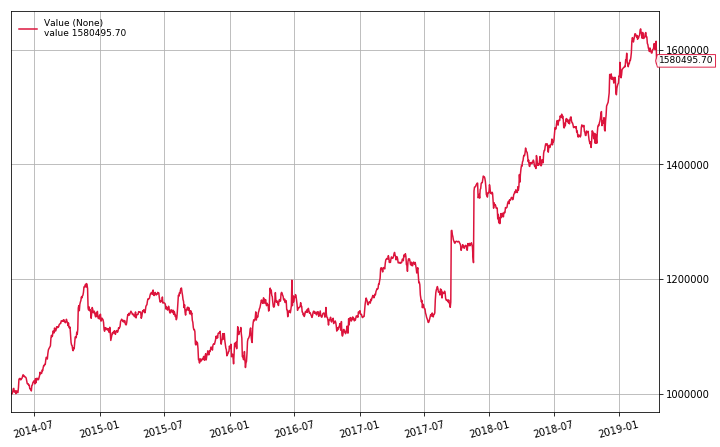

Max Drawdown: 12.27%
APR: 9.61%
Sharpe: 1.071


In [22]:
dd, cagr, sharpe = backtest(datas, CrossSectionalMR, plot=True, num_positions=100)
print(f"Max Drawdown: {dd:.2f}%\nAPR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

Now let's try the top 20:

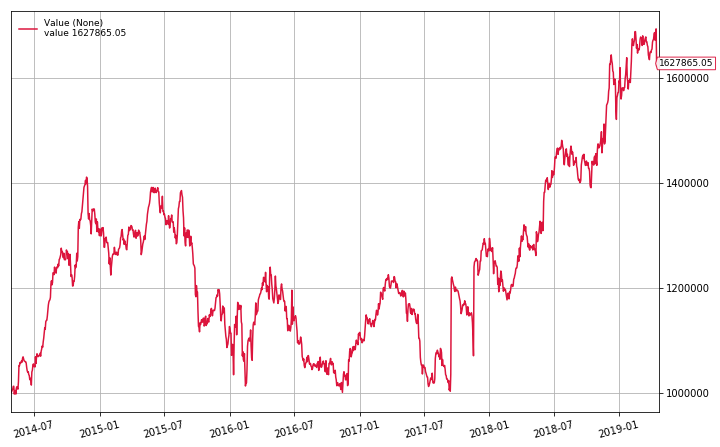

Max Drawdown: 29.10%
APR: 10.26%
Sharpe: 0.642


In [23]:
dd, cagr, sharpe = backtest(datas, CrossSectionalMR, plot=True, num_positions=20)
print(f"Max Drawdown: {dd:.2f}%\nAPR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

We can see that as we decrease the number of positions, we are increasing the volatility of the portfolio. Maybe if we only invest in stocks with lower volatility we'll see a better result.

### Volatility Filter

Now we will try using the same weight formula, but only trade stocks that are in the top <i>n</i> sorted by weight, and in the bottom <i>n</i>, sorted by 5-day standard deviation. In this way we will only trade stocks that have a comparatively high diversion from the mean returns of the universe, and comparatively low volatility. 

In [24]:
def min_n(array, n):
    return np.argpartition(array, n)[:n]

def max_n(array, n):
    return np.argpartition(array, -n)[-n:]

class CrossSectionalMR(bt.Strategy):
    params = (
        ('n', 100),
    )
    def __init__(self):
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {}
            self.inds[d]["pct"] = bt.indicators.PercentChange(d.close, period=5)
            self.inds[d]["std"] = bt.indicators.StandardDeviation(d.close, period=5)

    def prenext(self):
        self.next()
    
    def next(self):
        available = list(filter(lambda d: len(d) > 5, self.datas)) # only look at data that existed last week
        rets = np.zeros(len(available))
        stds = np.zeros(len(available))
        for i, d in enumerate(available):
            rets[i] = self.inds[d]['pct'][0]
            stds[i] = self.inds[d]['std'][0]

        market_ret = np.mean(rets)
        weights = -(rets - market_ret)
        max_weights_index = max_n(np.abs(weights), self.params.n)
        low_volality_index = min_n(stds, self.params.n)
        selected_weights_index = np.intersect1d(max_weights_index,
                                                low_volality_index)
        if not len(selected_weights_index):
            # no good trades today
            return
            
        selected_weights = weights[selected_weights_index]
        weights = weights / np.sum(np.abs(selected_weights))      
        for i, d in enumerate(available):
            if i in selected_weights_index:
                self.order_target_percent(d, target=weights[i])
            else:
                self.order_target_percent(d, 0)

As we can see above, we select the stocks to trade by computing the intersection between the maximal weight stocks and the minimal standard deviation stocks. Let's backtest it!

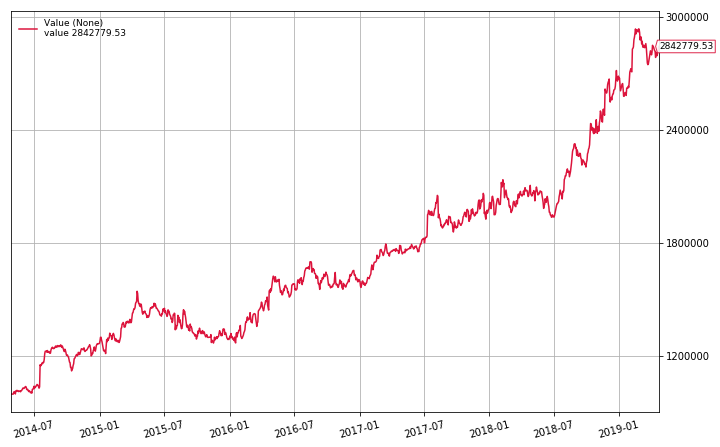

Max Drawdown: 17.77%
APR: 23.30%
Sharpe: 1.668


In [26]:
dd, cagr, sharpe = backtest(datas, CrossSectionalMR, plot=True, n=100)
print(f"Max Drawdown: {dd:.2f}%\nAPR: {cagr:.2f}%\nSharpe: {sharpe:.3f}")

The cross-sectional mean reversion strategy with volatility filter has an average annual return of 23.3% with a Sharpe ratio of 1.688. By these metrics this is our best performing algorithm so far! It is worth noting that we have introduced a few parameters (*n*, and the standard deviation window length) that we could optimize (and possibly overfit),but we will keep it as is for now. If you would like to experiment with my strategies for yourself, feel free to clone my [notebooks](https://github.com/teddykoker/blog/tree/master/notebooks) for yourself.

It is also worth noting that, like the previous mean-reversion algorithm, we do not account for survivorship bias in the S&P 500 over the 5 year period of our backtest.

In the next post we will try live trading the strategy!  Be sure to check out [Algorithmic Trading: Winning Strategies and Their Rationale](https://amzn.to/2VptDjd) for more strategy ideas.
